# Final project: Time-series data and application to stock markets {-}

This project aims at familiarizing you with time-series data analysis and its application to stock markets. Datasets you will be working on are Nasdaq and Vietnam stock datasets.

### Submission {-}
The structure of submission folder should be organized as follows:

- ./\<StudentID>-project-notebook.ipynb: Jupyter notebook containing source code.
- ./\<StudentID>-project-report.pdf: project report.

The submission folder is named DL4AI-\<StudentID>-project (e.g., DL4AI-2012345-project) and then compressed with the same name.
    
### Evaluation {-}
Project evaluation will be conducted on how you accomplish the assignment requirements. You can refer to the project instruction slide deck for details.

### Deadline {-}
Please visit Canvas for details.

# IMPORT NECESSARY LIBRARIES

In [1]:
import os
import pandas as pd
from pandas_datareader import data as pdr
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Bidirectional, LSTM, GRU, GlobalAveragePooling1D, Dropout
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# LOAD THE DATA

## Load the historical stock price data of top 100 companies on NASDAQ

In [ ]:
yf.pdr_override()

# Get the list of top 100 companies in NASDAQ
symbols = ["AAPL", "MSFT", "AMZN", "GOOGL", "FB", "NVDA", "TSLA", "PYPL", "ADBE", "INTC",
                 "CSCO", "CMCSA", "PEP", "NFLX", "AMGN", "AVGO", "TXN", "CHTR", "QCOM", "GILD",
                 "BKNG", "COST", "TMO", "CME", "AMD", "FISV", "INTU", "ISRG", "AMAT", "SBUX",
                 "MU", "VRTX", "JD", "MDLZ", "ADP", "ATVI", "REGN", "CSX", "BIIB", "MELI",
                 "KHC", "AEP", "MAR", "ADI", "NXPI", "IDXX", "LRCX", "EA", "EBAY", "ORLY",
                 "EXC", "SIRI", "BIDU", "VRSK", "CTSH", "PCAR", "CTAS", "WDC", "DLTR", "NTES",
                 "KLAC", "WBA", "WDAY", "XLNX", "SWKS", "FAST", "VRSN", "CERN", "SNPS", "ANSS",
                 "CDNS", "TTWO", "MXIM", "AAL", "PAYX", "ALXN", "LULU", "HAS", "MNST", "ROST",
                 "BMRN", "CPRT", "CTRP", "MTCH", "EXPE", "ULTA", "XEL", "ALGN", "JBHT", "CDW",
                 "NXST", "WLTW", "NTAP", "TTD", "CTVA", "TCOM", "UAL", "ALB", "IDXX"]

# Define the start and end date for the data
start_date = '2018-01-01'
end_date = '2023-02-02'

# Create an empty DataFrame to store the data
df = pd.DataFrame()

# Loop through the symbols and get the data
for symbol in symbols:
    data = pdr.get_data_yahoo(symbol, start=start_date, end=end_date)
    data['Symbol'] = symbol
    df = df.append(data)

# Reset the index of the DataFrame
df.reset_index(inplace=True)


In [4]:
# Save the data to a CSV file in Google Drive
df.to_csv('/content/drive/MyDrive/Final Project DL4AI/nasdaq_100_data.csv', index=False)

# PREPROCESS THE DATA

## Classify the loaded companies to their industries

In [5]:
# Get companies in NASDAQ-100
nasdaq_ticker_sector = pd.read_html('https://en.wikipedia.org/wiki/NASDAQ-100')[4]
nasdaq_ticker_sector = nasdaq_ticker_sector[['Ticker', 'GICS Sector']]

df = pd.read_csv('/content/drive/MyDrive/Final Project DL4AI/nasdaq_100_data.csv')

df['Industry'] = ''

for i, row in df.iterrows():
    symbol = row['Symbol']
    matching_row = nasdaq_ticker_sector[nasdaq_ticker_sector['Ticker'] == symbol]
    
    if not matching_row.empty:
        gics_sector = matching_row['GICS Sector'].iloc[0]
        df.at[i, 'Industry'] = gics_sector

In [6]:
# Save the data to a CSV file in Google Drive
df.to_csv('/content/drive/MyDrive/Final Project DL4AI/nasdaq_100_data_withIndustry.csv', index=False)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117410 entries, 0 to 117409
Data columns (total 9 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Date       117410 non-null  object 
 1   Open       117410 non-null  float64
 2   High       117410 non-null  float64
 3   Low        117410 non-null  float64
 4   Close      117410 non-null  float64
 5   Adj Close  117410 non-null  float64
 6   Volume     117410 non-null  float64
 7   Symbol     117410 non-null  object 
 8   Industry   117410 non-null  object 
dtypes: float64(6), object(3)
memory usage: 8.1+ MB


In [8]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Symbol,Industry
0,2018-01-02,42.540001,43.075001,42.314999,43.064999,40.831593,102223600.0,AAPL,Information Technology
1,2018-01-03,43.132500,43.637501,42.990002,43.057499,40.824474,118071600.0,AAPL,Information Technology
2,2018-01-04,43.134998,43.367500,43.020000,43.257500,41.014107,89738400.0,AAPL,Information Technology
3,2018-01-05,43.360001,43.842499,43.262501,43.750000,41.481060,94640000.0,AAPL,Information Technology
4,2018-01-08,43.587502,43.902500,43.482498,43.587502,41.326992,82271200.0,AAPL,Information Technology


## Preprocess the data based on the conditions stated in the final project's requirements

In [9]:
# Read the data from the CSV file
df = pd.read_csv('/content/drive/MyDrive/Final Project DL4AI/nasdaq_100_data_withIndustry.csv')

# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Sort the data by symbol and date
df.sort_values(['Symbol', 'Date'], inplace=True)

# Handle missing values
df.fillna(method='ffill', inplace=True)  # Forward fill missing values
df.fillna(method='bfill', inplace=True)  # Backward fill remaining missing values

# Filter out companies with insufficient historical data points
min_data_points = 120  # Minimum required data points

grouped = df.groupby('Symbol')
valid_companies = []
for symbol, data in grouped:
    if len(data) >= min_data_points:
        valid_companies.append(symbol)

df_filtered = df[df['Symbol'].isin(valid_companies)]

In [10]:
df_filtered.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Symbol,Industry
88320,2018-01-02,52.330002,53.099998,51.900002,52.990002,51.647560,4084700.0,AAL,Information Technology
88321,2018-01-03,52.860001,52.860001,52.060001,52.340000,51.014023,5074900.0,AAL,Information Technology
88322,2018-01-04,52.480000,54.400002,52.270000,52.669998,51.335670,3557100.0,AAL,Information Technology
88323,2018-01-05,52.779999,52.840000,52.430000,52.650002,51.316181,2967800.0,AAL,Information Technology
88324,2018-01-08,52.599998,52.639999,51.930000,52.130001,50.809345,3515800.0,AAL,Information Technology


## Filter the company list to only remain companies from the industry of "Industrials"

In [11]:
# Filter based on the industry
industry_filter = ['Industrials']
df_filtered = df_filtered[df_filtered['Industry'].isin(industry_filter)]

df_filtered.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Symbol,Industry
97280,2018-01-02,21.760000,21.834999,21.594999,21.799999,21.799999,1724000.0,CPRT,Industrials
97281,2018-01-03,21.815001,21.924999,21.600000,21.695000,21.695000,2312800.0,CPRT,Industrials
97282,2018-01-04,21.750000,21.975000,21.650000,21.870001,21.870001,2336000.0,CPRT,Industrials
97283,2018-01-05,21.885000,21.940001,21.514999,21.764999,21.764999,1849200.0,CPRT,Industrials
97284,2018-01-08,21.795000,21.930000,21.639999,21.775000,21.775000,2508400.0,CPRT,Industrials


In [12]:
# Save the preprocessed data to a new CSV file
df_filtered.to_csv("/content/drive/MyDrive/Final Project DL4AI/nasdaq_data_preprocessed.csv", index=False)

## Detach companies into separate .csv files

In [13]:
# Read the data from the CSV file
df_preprocessed = pd.read_csv('/content/drive/MyDrive/Final Project DL4AI/nasdaq_data_preprocessed.csv')

# Loop through the symbols and filter the data
for symbol in symbols:
    # Filter the data for the current symbol
    symbol_data = df_preprocessed[df_preprocessed['Symbol'] == symbol]
    if len(symbol_data["Close"]) < 1:
      continue
    # Define the output file path
    output_file = f'/content/drive/MyDrive/Final Project DL4AI/nasdaq_preprocessed/{symbol}.csv'
    
    # Save the symbol-specific data to a CSV file
    symbol_data.to_csv(output_file, index=False)


In [14]:
# Import all the extracted .csv files
path = '/content/drive/MyDrive/Final Project DL4AI/nasdaq_preprocessed'
csv_files = []

for filename in os.listdir(path):
    if filename.endswith('.csv'):
        file_path = os.path.join(path, filename)
        csv_files.append(file_path)

# Display the list of CSV files
print("Number of the remaining companies: ", len(csv_files))

Number of the remaining companies:  7


# PROCESS THE DATA

## Utility functions

In [15]:
# Load and preprocess the data
def load_data(file_path):
    data = pd.read_csv(file_path)
    data = data[['Date', 'Close']]  # Keep only the date and closing price columns
    data['Date'] = pd.to_datetime(data['Date'])  # Convert date column to datetime
    data.set_index('Date', inplace=True)  # Set date as the index
    return data

def preprocess_data(data):
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data.values.reshape(-1, 1))
    return scaled_data, scaler

# Prepare the data for the LSTM model
def prepare_data(data, time_steps, train_ratio):
    train_size = int(len(data) * train_ratio)
    train_data = data[:train_size]
    test_data = data[train_size + time_steps:]

    X_train, y_train = [], []
    for i in range(len(train_data) - time_steps - 1):
        X_train.append(train_data[i:(i + time_steps), 0])
        y_train.append(train_data[(i + time_steps), 0])

    X_test, y_test = [], []
    for i in range(len(test_data) - time_steps - 1):
        X_test.append(test_data[i:(i + time_steps), 0])
        y_test.append(test_data[(i + time_steps), 0])

    return np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test)

# Build the LSTM model
def build_model(time_steps, num_features):
    model = Sequential()
    model.add(LSTM(units=32, return_sequences=True, input_shape=(time_steps, num_features)))
    model.add(LSTM(units=32))
    model.add(Dropout(0.5))
    model.add(Dense(units=8, activation = 'relu'))
    model.add(Dense(units=1, activation = 'sigmoid'))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Make predictions using the LSTM model
def make_predictions(model, X):
    return model.predict(X)

# Function to create a trade table
def create_trade_table(dates, prices):
    trade_table = pd.DataFrame({'Date': dates, 'Price': prices})
    trade_table['Action'] = trade_table['Price'].diff().apply(lambda x: 'Buy' if x > 0 else 'Sell')
    return trade_table

# Function to plot the predicted prices
def plot_predicted_prices(data, unscaled_predictions, company_file):
    plt.figure(figsize=(10, 6))
    plt.plot(data.index[-len(unscaled_predictions):], data['Close'].values[-len(unscaled_predictions):], label='Actual Price')
    plt.plot(data.index[-len(unscaled_predictions):], unscaled_predictions, label='Predicted Price')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title('Price Prediction for {}'.format(company_file))
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()

def basename(path):
    filename = os.path.basename(path)
    filename = os.path.splitext(filename)[0]
    return filename

## Hyper-parameters

In [16]:
# Hyperparameters
time_steps = 30
epochs = 200
batch_size = 4096
num_companies = len(csv_files)
train_ratio = 0.8  # Ratio of data used for training

## Split the data into training/testing sets

In [17]:
# List of companies (file paths to their historical stock price data)
company_list = csv_files

# Load and preprocess data for each company
data_list = []
scaler_list = []
for company_file in company_list:
    data = load_data(company_file)
    scaled_data, scaler = preprocess_data(data)
    data_list.append(scaled_data)
    scaler_list.append(scaler)

# Prepare the data for the LSTM model
X_train_list, y_train_list, X_test_list, y_test_list = [], [], [], []
for data in data_list:
    X_train, y_train, X_test, y_test = prepare_data(data, time_steps, train_ratio)
    X_train_list.append(X_train)
    y_train_list.append(y_train)
    X_test_list.append(X_test)
    y_test_list.append(y_test)

# Concatenate the data from all companies
X_train = np.concatenate(X_train_list)
y_train = np.concatenate(y_train_list)
X_test = np.concatenate(X_test_list)
y_test = np.concatenate(y_test_list)

# Reshape the input data for the LSTM model
num_samples, num_features = X_train.shape[0], X_train.shape[1]
X_train = X_train.reshape(num_samples, num_features, 1)
num_samples_test = X_test.shape[0]
X_test = X_test.reshape(num_samples_test, num_features, 1)

## Build and train the LSTM model

In [18]:
# Build the LSTM model
model = build_model(num_features, 1)

In [19]:
# Train the LSTM model
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size)

Epoch 1/200
2/2 [==============================] - 6s 465ms/step - loss: 0.0632
Epoch 2/200
2/2 [==============================] - 1s 453ms/step - loss: 0.0611
Epoch 3/200
2/2 [==============================] - 1s 437ms/step - loss: 0.0584
Epoch 4/200
2/2 [==============================] - 1s 444ms/step - loss: 0.0556
Epoch 5/200
2/2 [==============================] - 1s 431ms/step - loss: 0.0524
Epoch 6/200
2/2 [==============================] - 1s 431ms/step - loss: 0.0486
Epoch 7/200
2/2 [==============================] - 1s 679ms/step - loss: 0.0444
Epoch 8/200
2/2 [==============================] - 2s 704ms/step - loss: 0.0391
Epoch 9/200
2/2 [==============================] - 2s 662ms/step - loss: 0.0330
Epoch 10/200
2/2 [==============================] - 1s 415ms/step - loss: 0.0259
Epoch 11/200
2/2 [==============================] - 1s 428ms/step - loss: 0.0192
Epoch 12/200
2/2 [==============================] - 1s 424ms/step - loss: 0.0141
Epoch 13/200
2/2 [===================

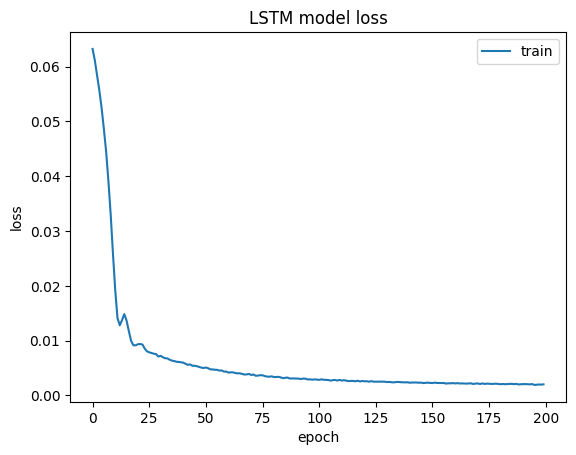

In [20]:
# Visualize the training loss over epochs
plt.plot(history.history['loss'])
plt.title('LSTM model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper right')
plt.show()

In [21]:
# Get prediction on the test data
y_pred_norm = model.predict(X_test)
print("MSE on the test set: ", mean_squared_error(y_pred_norm, y_test))

43/43 [==============================] - 1s 8ms/step
MSE on the test set:  0.0023600130294003808


# ILLUSTRATE THE PREDICTIONS

In [22]:
# Load and preprocess data for each company
data_list = []
scaler_list = []
for company_file in company_list:
    data = load_data(company_file)
    scaled_data, scaler = preprocess_data(data)
    data_list.append(data)  # Store unscaled data for plotting
    scaler_list.append(scaler)

In [23]:
# Make predictions for each company
predictions_list = []
for i, X in enumerate(X_test_list):
    X = X.reshape(X.shape[0], X.shape[1], 1)
    predictions = make_predictions(model, X)
    predictions_list.append(predictions)

7/7 [==============================] - 0s 8ms/step


Trade table for CSX
          Date      Price Action
0   2022-04-25  35.569359   Sell
1   2022-04-26  35.578575    Buy
2   2022-04-27  35.575661   Sell
3   2022-04-28  35.544991   Sell
4   2022-04-29  35.502338   Sell
..         ...        ...    ...
190 2023-01-26  32.321968   Sell
191 2023-01-27  32.204002   Sell
192 2023-01-30  31.980616   Sell
193 2023-01-31  31.683380   Sell
194 2023-02-01  31.337612   Sell

[195 rows x 3 columns]

Trade table saved to: /content/drive/MyDrive/Final Project DL4AI/trade_tables/CSX_trade_table.csv


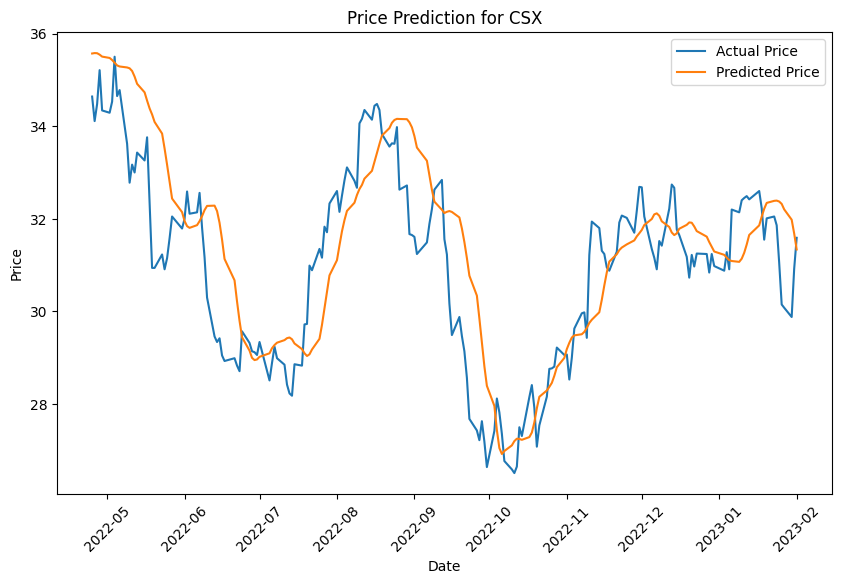

Trade table for PCAR
          Date      Price Action
0   2022-04-25  56.811054   Sell
1   2022-04-26  57.527443    Buy
2   2022-04-27  58.166988    Buy
3   2022-04-28  58.450706    Buy
4   2022-04-29  58.530552    Buy
..         ...        ...    ...
190 2023-01-26  67.914757    Buy
191 2023-01-27  68.475067    Buy
192 2023-01-30  69.163376    Buy
193 2023-01-31  69.752541    Buy
194 2023-02-01  70.254951    Buy

[195 rows x 3 columns]

Trade table saved to: /content/drive/MyDrive/Final Project DL4AI/trade_tables/PCAR_trade_table.csv


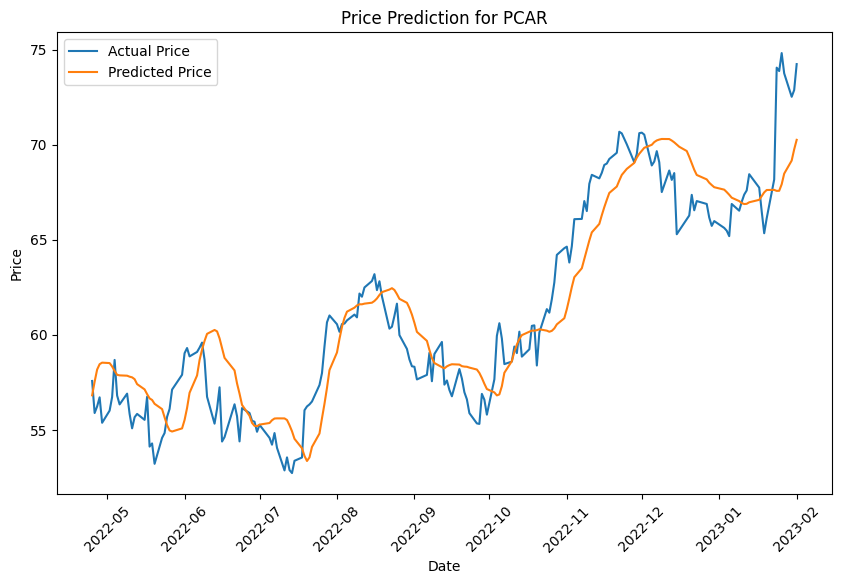

Trade table for FAST
          Date      Price Action
0   2022-04-25  58.296097   Sell
1   2022-04-26  58.150639   Sell
2   2022-04-27  58.038242   Sell
3   2022-04-28  57.908104   Sell
4   2022-04-29  57.754471   Sell
..         ...        ...    ...
190 2023-01-26  49.141964    Buy
191 2023-01-27  49.244068    Buy
192 2023-01-30  49.372578    Buy
193 2023-01-31  49.563229    Buy
194 2023-02-01  49.721237    Buy

[195 rows x 3 columns]

Trade table saved to: /content/drive/MyDrive/Final Project DL4AI/trade_tables/FAST_trade_table.csv


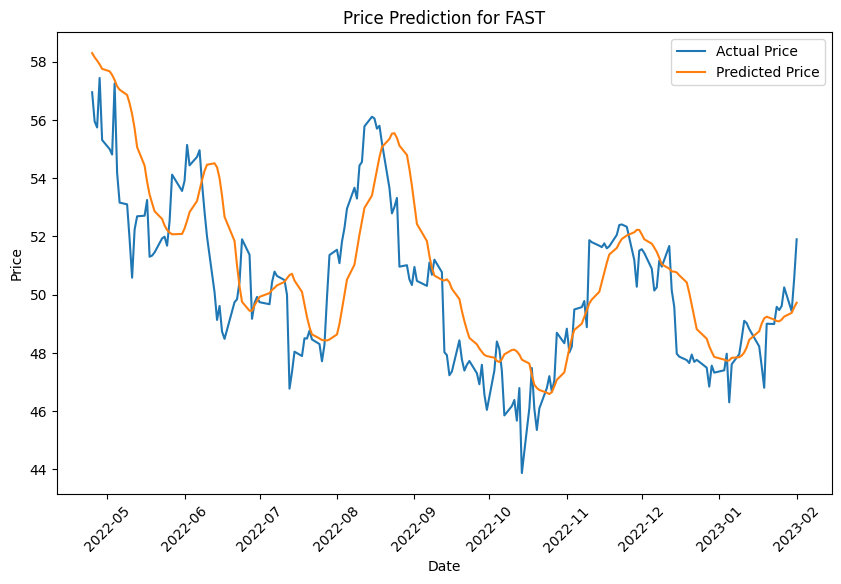

Trade table for VRSN
          Date       Price Action
0   2022-04-25  216.386063   Sell
1   2022-04-26  215.465027   Sell
2   2022-04-27  214.573227   Sell
3   2022-04-28  213.416962   Sell
4   2022-04-29  211.960907   Sell
..         ...         ...    ...
190 2023-01-26  214.086319    Buy
191 2023-01-27  214.607590    Buy
192 2023-01-30  215.162811    Buy
193 2023-01-31  215.752258    Buy
194 2023-02-01  216.202515    Buy

[195 rows x 3 columns]

Trade table saved to: /content/drive/MyDrive/Final Project DL4AI/trade_tables/VRSN_trade_table.csv


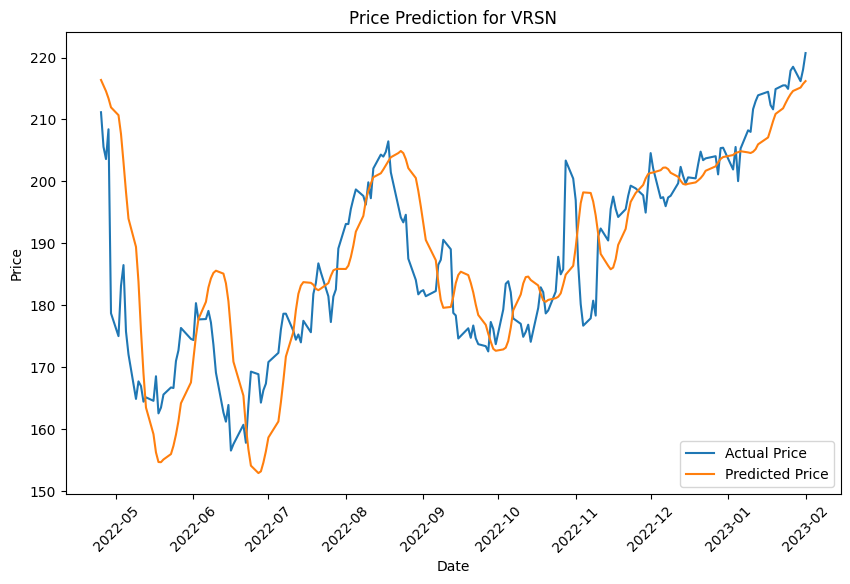

Trade table for CPRT
          Date      Price Action
0   2022-04-25  59.923687   Sell
1   2022-04-26  59.611935   Sell
2   2022-04-27  59.379753   Sell
3   2022-04-28  59.083069   Sell
4   2022-04-29  58.705063   Sell
..         ...        ...    ...
190 2023-01-26  63.247009    Buy
191 2023-01-27  63.622246    Buy
192 2023-01-30  64.096245    Buy
193 2023-01-31  64.637596    Buy
194 2023-02-01  65.135178    Buy

[195 rows x 3 columns]

Trade table saved to: /content/drive/MyDrive/Final Project DL4AI/trade_tables/CPRT_trade_table.csv


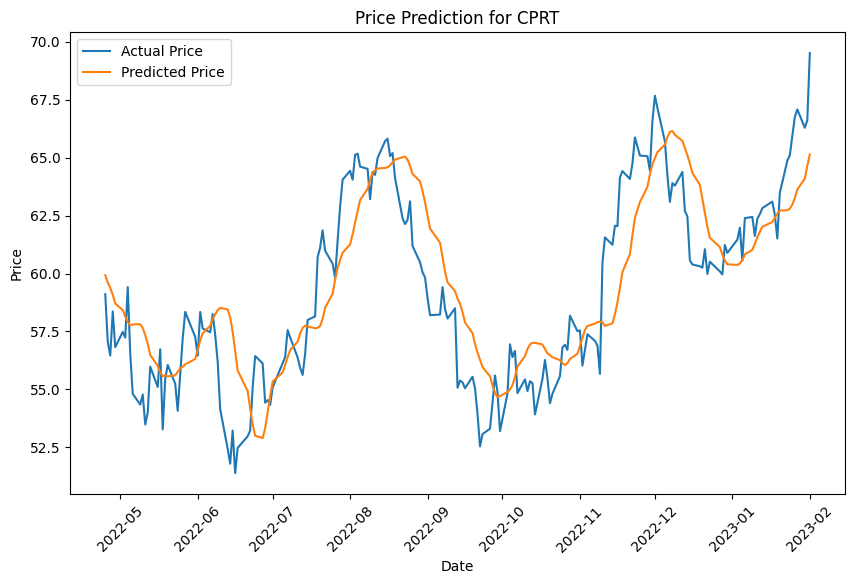

Trade table for VRSK
          Date       Price Action
0   2022-04-25  217.089462   Sell
1   2022-04-26  217.007645   Sell
2   2022-04-27  216.919571   Sell
3   2022-04-28  216.694565   Sell
4   2022-04-29  216.324478   Sell
..         ...         ...    ...
190 2023-01-26  183.425949   Sell
191 2023-01-27  183.080215   Sell
192 2023-01-30  182.697693   Sell
193 2023-01-31  182.242691   Sell
194 2023-02-01  181.735382   Sell

[195 rows x 3 columns]

Trade table saved to: /content/drive/MyDrive/Final Project DL4AI/trade_tables/VRSK_trade_table.csv


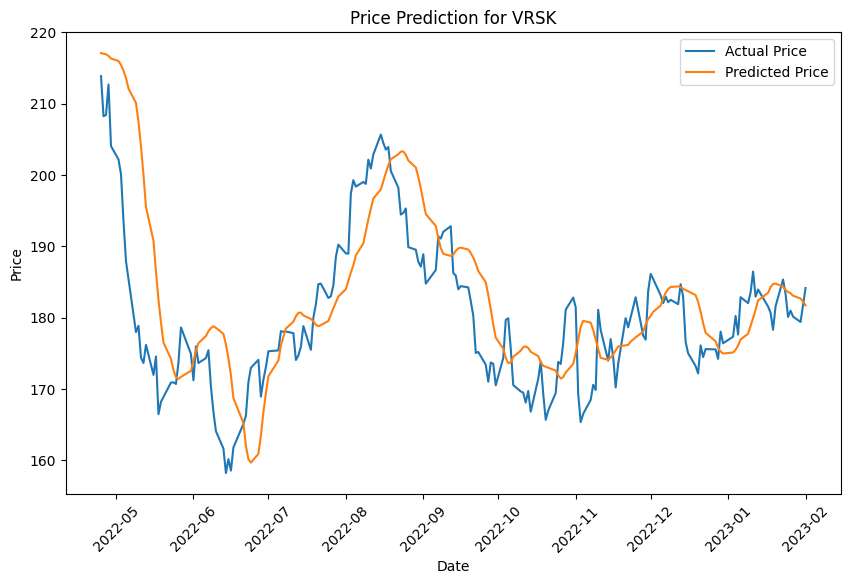

Trade table for CTAS
          Date       Price Action
0   2022-04-25  425.592194   Sell
1   2022-04-26  424.867615   Sell
2   2022-04-27  424.014435   Sell
3   2022-04-28  422.684753   Sell
4   2022-04-29  421.061890   Sell
..         ...         ...    ...
190 2023-01-26  443.775970   Sell
191 2023-01-27  443.308014   Sell
192 2023-01-30  442.932861   Sell
193 2023-01-31  442.581787   Sell
194 2023-02-01  442.240814   Sell

[195 rows x 3 columns]

Trade table saved to: /content/drive/MyDrive/Final Project DL4AI/trade_tables/CTAS_trade_table.csv


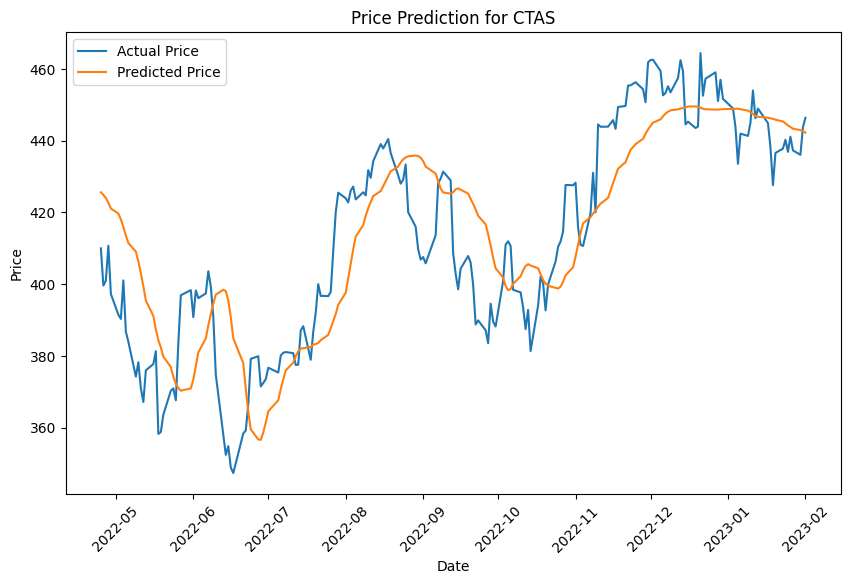

In [24]:
# Create trade table and plot predicted prices for each company
for i, company_file in enumerate(company_list):
    data = data_list[i]
    predictions = predictions_list[i]
    unscaled_predictions = scaler_list[i].inverse_transform(predictions)
    unscaled_predictions = unscaled_predictions.flatten()  # Reshape to 1-dimensional array
    dates = data.index[-len(unscaled_predictions):]

    trade_table = create_trade_table(dates, unscaled_predictions)
    print("Trade table for", basename(company_file))
    print(trade_table)
    print()

    # Save trade table to CSV file
    output_file = f'/content/drive/MyDrive/Final Project DL4AI/trade_tables/{basename(company_file)}_trade_table.csv'
    trade_table.to_csv(output_file, index=False)
    print("Trade table saved to:", output_file)

    plot_predicted_prices(data, unscaled_predictions, basename(company_file))

# CREATE PORTFOLIO FOR COMPANIES IN INDUSTRALS

In [25]:
# Make predictions for each company
predictions_list = []
for i, X in enumerate(X_test_list):
    X = X.reshape(X.shape[0], X.shape[1], 1)
    predictions = make_predictions(model, X)
    unscaled_predictions = scaler_list[0].inverse_transform(predictions.reshape(-1, 1))
    predictions_list.append(predictions)

7/7 [==============================] - 0s 10ms/step


In [26]:
profit_list = []
for i in range(num_companies):
    trade_table = create_trade_table(data_list[i].index[-len(predictions_list[i]):], predictions_list[i].reshape(-1))
    buy_prices = trade_table[trade_table['Action'] == 'Buy']['Price'].values
    sell_prices = trade_table[trade_table['Action'] == 'Sell']['Price'].values
    
    min_len = min(len(buy_prices), len(sell_prices))
    buy_prices = buy_prices[:min_len]
    sell_prices = sell_prices[:min_len]
    
    profit = np.sum(sell_prices - buy_prices)
    profit_list.append(profit)

In [27]:
hold_list = [company_list[i] for i in range(num_companies) if profit_list[i] >= 0]
get_rid_list = [company_list[i] for i in range(num_companies) if profit_list[i] < 0]

print("Companies to Hold:")
for company in hold_list:
    print(basename(company))

print("\nCompanies to Get Rid of:")
for company in get_rid_list:
    print(basename(company))

Companies to Hold:
CSX
FAST
VRSN
CPRT
VRSK
CTAS

Companies to Get Rid of:
PCAR


In [28]:
potential_scores = []
risk_scores = []

for i in range(num_companies):
    potential_score = profit_list[i] / abs(np.min(profit_list))  # Potential score calculation
    risk_score = np.std(data_list[i]['Close'])  # Risk score calculation
    
    potential_scores.append(potential_score)
    risk_scores.append(risk_score)

# Display the potential scores and risk scores for each company
for i in range(num_companies):
    print(f"Company: {basename(company_list[i])}")
    print(f"Potential Score: {potential_scores[i]}")
    print(f"Risk Score: {risk_scores[i]}")
    print()

Company: CSX
Potential Score: 1.7022085189819336
Risk Score: 5.181173914191544

Company: PCAR
Potential Score: -1.0
Risk Score: 8.136286116013505

Company: FAST
Potential Score: 0.765029788017273
Risk Score: 11.061934325063833

Company: VRSN
Potential Score: 0.7978691458702087
Risk Score: 31.45205656929767

Company: CPRT
Potential Score: 0.13042597472667694
Risk Score: 15.9831339429641

Company: VRSK
Potential Score: 0.8753677010536194
Risk Score: 34.326089658068895

Company: CTAS
Potential Score: 0.6958950161933899
Risk Score: 92.3186536102287



In [29]:
# Create a dictionary to store the data
portfolio_data = {
    'Company': [],
    'Profit': [],
    'Potential Score': [],
    'Risk Score': [],
    'Action': []
}

# Populate the portfolio_data dictionary
for i in range(num_companies):
    if company_list[i] in hold_list:
        action = 'Hold'
    elif company_list[i] in get_rid_list:
        action = 'Get Rid'
    else:
        action = 'No Action'

    portfolio_data['Company'].append(basename(company_list[i]))
    portfolio_data['Profit'].append(profit_list[i])
    portfolio_data['Potential Score'].append(potential_scores[i])
    portfolio_data['Risk Score'].append(risk_scores[i])
    portfolio_data['Action'].append(action)

# Create a DataFrame from the portfolio_data dictionary
portfolio_df = pd.DataFrame(portfolio_data)

# Display the portfolio
print(portfolio_df)


  Company    Profit  Potential Score  Risk Score   Action
0     CSX  5.133781         1.702209    5.181174     Hold
1    PCAR -3.015953        -1.000000    8.136286  Get Rid
2    FAST  2.307294         0.765030   11.061934     Hold
3    VRSN  2.406336         0.797869   31.452057     Hold
4    CPRT  0.393359         0.130426   15.983134     Hold
5    VRSK  2.640068         0.875368   34.326090     Hold
6    CTAS  2.098787         0.695895   92.318654     Hold


In [30]:
# Save the DataFrame to a CSV file
outputfile = f'/content/drive/MyDrive/Final Project DL4AI/portfolio.csv'
portfolio_df.to_csv(outputfile, index=False)
print("Portfolio saved to:", outputfile)

Portfolio saved to: /content/drive/MyDrive/Final Project DL4AI/portfolio.csv
